# Prediction using LSTM, GRU-LSTM, xLSTM

In [11]:
import copy
import json
import pickle
from typing import List

import matplotlib.pyplot as plt
import numpy as np
# Data analysis, preprocessing and math
import pandas as pa
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from numpy.lib._stride_tricks_impl import sliding_window_view
from pandas import DataFrame
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from torch.utils.data import DataLoader, Dataset, Subset

# Import packages
# Core

In [12]:
# CONFIG GLOBALS

SAVE_ENABLED = True
SERIAL_NUMBER = "+YEARLY_GDP_AVERAGE"

## 3D Tensor Preparation

Pytorch expect a 3D Tensor.

In [13]:
processed = pa.read_parquet(path="../data/model/processed.parquet", engine="fastparquet")
df: DataFrame = processed.copy(deep=True)

In [14]:
"""
------ NORMALIZE DATA ------
- Normalize data with RobustScaler -> IMPORT, EXPORT, GDP_reporter, GDP_partner
"""

SEQ_LEN = 5
HORIZON = 1
BATCH_SIZE = 256
NUM_EPOCHS = 100
PATIENCE = 10
N_SPLITS = 5
RANDOM_SEED = 16
N_LAGS = 5

torch.manual_seed(16)

device = (
  torch.device("mps") if torch.backends.mps.is_available()
  else torch.device("cpu")
)

# Sort data to reproduce windows
df["dyad_id"] = df["ISO3_reporter"] + "_" + df["ISO3_partner"]
df = df.sort_values(by=["dyad_id", "Year"], ignore_index=True)

FEATURES: List[str] = ["GDP_reporter", "GDP_partner", "distw", "TOTAL", "arms", "military",
                       "trade", "financial", "travel", "other", "contig", "comlang_off", "colony", "smctry",
                       "Year_feature"
                       ]
df["Year_feature"] = df["Year"]
TARGET = "gravity_trade"

# Calculate gravity_trade with the original scale

df["gravity_trade"] = np.log1p((df["GDP_reporter"] * df["GDP_partner"]) / df["distw"])
df["TOTAL"] = df["IMPORT"] + df["EXPORT"]

df["target_next"] = (
  df.groupby("dyad_id")["gravity_trade"]
  .shift(-1)
)
df = df.dropna(subset=["target_next"]).reset_index(drop=True)

In [15]:
# Scale data
scale_columns_minmax: List[str] = ["GDP_reporter", "GDP_partner", "IMPORT", "EXPORT", "TOTAL", "GDP_yearly_average",
                                   "Year_feature"]
scaler_rb = RobustScaler()
scaler_mm = MinMaxScaler()
df_scaled: DataFrame = df.copy(deep=True)
df_scaled[scale_columns_minmax] = scaler_mm.fit_transform(df[scale_columns_minmax])
df_scaled[["distw"]] = scaler_rb.fit_transform(df[["distw"]])

In [16]:
# df_scaled["Year"] = df_scaled["Year"].astype("category")

In [17]:
df_scaled

,ISO3_reporter,UNDS_reporter,CNAME_reporter,ISO3_partner,UNDS_partner,CNAME_partner,Year,GDP_reporter,GDP_partner,contig,...,travel,other,target_mult,sender_mult,GDP_yearly_average,dyad_id,Year_feature,gravity_trade,TOTAL,target_next
0,AGO,024,Angola,ALB,008,Albania,1988,0.000337,0.000079,False,...,0.0,0.0,0.0,0.0,0.000000,AGO_ALB,0.000000,35.686523,0.000000,35.931627
1,AGO,024,Angola,ALB,008,Albania,1989,0.000392,0.000086,False,...,0.0,0.0,0.0,0.0,0.011663,AGO_ALB,0.029412,35.931627,0.000000,35.922631
2,AGO,024,Angola,ALB,008,Albania,1990,0.000432,0.000078,False,...,0.0,0.0,0.0,0.0,0.025212,AGO_ALB,0.058824,35.922631,0.000000,35.252882
3,AGO,024,Angola,ALB,008,Albania,1991,0.000407,0.000042,False,...,0.0,0.0,0.0,0.0,0.034902,AGO_ALB,0.088235,35.252882,0.000000,34.486516
4,AGO,024,Angola,ALB,008,Albania,1992,0.000319,0.000025,False,...,0.0,0.0,0.0,0.0,0.054715,AGO_ALB,0.117647,34.486516,0.000000,34.719221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102730,ZWE,716,Zimbabwe,ZMB,894,Zambia,2018,0.001313,0.001011,True,...,0.0,0.0,0.0,0.0,0.810775,ZWE_ZMB,0.882353,41.877928,0.000304,41.472975
1102731,ZWE,716,Zimbabwe,ZMB,894,Zambia,2019,0.000989,0.000896,True,...,0.0,0.0,0.0,0.0,0.826409,ZWE_ZMB,0.911765,41.472975,0.000195,41.265911
1102732,ZWE,716,Zimbabwe,ZMB,894,Zambia,2020,0.001033,0.000697,True,...,0.0,0.0,0.0,0.0,0.796276,ZWE_ZMB,0.941176,41.265911,0.000206,41.477102
1102733,ZWE,716,Zimbabwe,ZMB,894,Zambia,2021,0.001047,0.000849,True,...,0.0,0.0,0.0,0.0,0.950862,ZWE_ZMB,0.970588,41.477102,0.000330,41.940025


In [18]:
"""
----- BASIC LSTM MODEL -----
"""


class BasicLSTM(nn.Module):
  def __init__(self,
               n_features: int,
               hidden_size: int = 128,
               n_layers: int = 2,
               dropout: float = 0.3):
    super(BasicLSTM, self).__init__()

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=hidden_size,
      num_layers=n_layers,
      dropout=dropout,
      batch_first=True
    )
    self.gate = nn.Linear(n_features + hidden_size, hidden_size)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, data):
    lstm_out, _ = self.lstm(data)
    return self.fc(lstm_out[:, -1]).squeeze(1)

In [19]:
# Sliding window for lagged features

SEQ_LEN = 5  # window = 3 past years
HORIZON = 1  # predict t+1


class WindowDataset(Dataset):
  def __init__(self, frame, feature_cols, target_col):
    L, H = SEQ_LEN, HORIZON
    shift = L + H - 1

    feats = frame[feature_cols].to_numpy(np.float32)
    target = frame[target_col].to_numpy(np.float32)
    did = frame["dyad_id"].to_numpy()
    yrs = frame["Year"].to_numpy()

    starts = np.arange(len(frame) - shift)
    mask = (did[starts] == did[starts + shift]) & \
           (yrs[starts + shift] == yrs[starts] + shift)
    self.starts = starts[mask]
    self.shift = shift
    self.all_win = sliding_window_view(feats, L, axis=0)

    self.target = target

  def __len__(self):          return len(self.starts)

  def __getitem__(self, idx_tmp):
    s = self.starts[idx_tmp]
    X_tmp = torch.from_numpy(self.all_win[s].T.copy()).float()
    y_tmp = torch.tensor(self.target[s + self.shift], dtype=torch.float32)
    return X_tmp, y_tmp, s + self.shift

In [20]:
"""
----- Dataset and Split -----
"""
dataset = WindowDataset(
  frame=df_scaled,
  feature_cols=FEATURES,
  target_col="target_next"
)

# ------------------------------------------------------------------
# 2.  Train / val / test split on window indices
# ------------------------------------------------------------------
idx = np.arange(len(dataset))
train_idx, test_idx = train_test_split(
  idx, test_size=0.20, random_state=16
)
train_idx, val_idx = train_test_split(
  train_idx, test_size=0.20 / 0.80, random_state=16
)

# ------------------------------------------------------------------
# 3.  DataLoaders
# ------------------------------------------------------------------
train_loader = DataLoader(
  Subset(dataset, train_idx),
  batch_size=BATCH_SIZE,
  shuffle=True
)
print("✳️Train loader ready")

val_loader = DataLoader(
  Subset(dataset, val_idx),
  batch_size=BATCH_SIZE,
  shuffle=False
)
print("✳️Validation loader ready")

test_loader = DataLoader(
  Subset(dataset, test_idx),
  batch_size=BATCH_SIZE,
  shuffle=False
)
print("✳️Test loader ready")

✳️Train loader ready
✳️Validation loader ready
✳️Test loader ready


In [21]:
"""
---- K-FOLD ----
"""

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

best_fold_state = None  # global best
best_fold_rmse = float("inf")
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset))), 1):
  print(f"=== 🔌 FOLD {fold}/{N_SPLITS} ===")

  train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=BATCH_SIZE,
    shuffle=True
  )
  print("✳️Train loader ready")

  val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=BATCH_SIZE,
    shuffle=False
  )
  print("✳️Validation loader ready")

  model = BasicLSTM(n_features=len(FEATURES)).to(device=device)

  criterion = nn.MSELoss()
  optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
  )

  best_state = copy.deepcopy(model.state_dict())
  best_rmse = float("inf")
  patience_left = PATIENCE

  for epoch in range(NUM_EPOCHS):
    # --- train ---
    model.train()
    for X, y, _ in train_loader:
      X = X.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      loss = criterion(model(X), y)
      loss.backward()
      optimizer.step()

    # --- val ---
    model.eval()
    val_losses = []
    with (torch.no_grad()):
      for X, y, _ in val_loader:
        X = X.to(device)
        y = y.to(device)
        val_losses.append(criterion(model(X), y).item())

    val_rmse = (sum(val_losses) / len(val_losses)) ** 0.5
    scheduler.step(val_rmse)
    print(f"🌯 Epoch {epoch + 1:02d}  |  val RMSE: {val_rmse:.4f}")

    if val_rmse < best_rmse - 1e-4:
      best_rmse, patience_left = val_rmse, 10
      best_state = model.state_dict()
    else:
      patience_left -= 1
      if patience_left == 0:
        print("🛑 Early stop.")
        break

  model.load_state_dict(best_state)
  model.eval();
  preds, truth = [], []
  with torch.no_grad():
    for X, y, _ in val_loader:  # “val” acts as test in CV fold
      X = X.to(device)
      preds.append(model(X).cpu());
      truth.append(y)
  preds = torch.cat(preds).numpy()
  truth = torch.cat(truth).numpy()

  rmse = np.sqrt(((preds - truth) ** 2).mean())
  mae = np.abs(preds - truth).mean()
  r2 = 1 - ((preds - truth) ** 2).sum() / ((truth - truth.mean()) ** 2).sum()
  fold_metrics.append((rmse, mae, r2))
  print(f" ⭐️ Fold {fold}  RMSE {rmse:.4f} | MAE {mae:.4f} | R² {r2:.4f}")
  if rmse < best_fold_rmse:
    best_fold_rmse = rmse
    best_fold_state = copy.deepcopy(best_state)

rmse_avg = np.mean([m[0] for m in fold_metrics])
mae_avg = np.mean([m[1] for m in fold_metrics])
r2_avg = np.mean([m[2] for m in fold_metrics])
print(f"\n💡 5‑fold mean  RMSE {rmse_avg:.4f} | MAE {mae_avg:.4f} | R² {r2_avg:.4f}")

=== 🔌 FOLD 1/5 ===
✳️Train loader ready
✳️Validation loader ready
🌯 Epoch 01  |  val RMSE: 1.8879
🌯 Epoch 02  |  val RMSE: 1.7967
🌯 Epoch 03  |  val RMSE: 1.6019
🌯 Epoch 04  |  val RMSE: 1.5805
🌯 Epoch 05  |  val RMSE: 1.5024
🌯 Epoch 06  |  val RMSE: 1.4822
🌯 Epoch 07  |  val RMSE: 1.4796
🌯 Epoch 08  |  val RMSE: 1.4599
🌯 Epoch 09  |  val RMSE: 1.4909
🌯 Epoch 10  |  val RMSE: 1.4412
🌯 Epoch 11  |  val RMSE: 1.4261
🌯 Epoch 12  |  val RMSE: 1.4984
🌯 Epoch 13  |  val RMSE: 1.4218
🌯 Epoch 14  |  val RMSE: 1.4437
🌯 Epoch 15  |  val RMSE: 1.4003
🌯 Epoch 16  |  val RMSE: 1.4033
🌯 Epoch 17  |  val RMSE: 1.3987
🌯 Epoch 18  |  val RMSE: 1.3955
🌯 Epoch 19  |  val RMSE: 1.3904
🌯 Epoch 20  |  val RMSE: 1.4287
🌯 Epoch 21  |  val RMSE: 1.3923
🌯 Epoch 22  |  val RMSE: 1.3706
🌯 Epoch 23  |  val RMSE: 1.3812
🌯 Epoch 24  |  val RMSE: 1.3791
🌯 Epoch 25  |  val RMSE: 1.3776
🌯 Epoch 26  |  val RMSE: 1.3878
🌯 Epoch 27  |  val RMSE: 1.3370
🌯 Epoch 28  |  val RMSE: 1.3387
🌯 Epoch 29  |  val RMSE: 1.3472
🌯 Epoc

In [22]:
if SAVE_ENABLED:
  # 1.  model weights -------------------------------------------------
  torch.save(best_fold_state, f"../models/lstm_weights-{SERIAL_NUMBER}.pt")

  # 2.  preprocessing objects ----------------------------------------
  prep = {
    "minmax_scaler": scaler_mm,
    "robust_scaler": scaler_rb,
    "feature_cols": FEATURES,
  }
  with open(f"../models/prep_objects.pkl", "wb") as f:
    pickle.dump(prep, f)

  # 3.  run‑time config ----------------------------------------------
  cfg = {
    "seq_len": SEQ_LEN,
    "horizon": HORIZON,
    "hidden_size": 128,
    "n_layers": 2,
    "dropout": 0.3,
    "batch_size": BATCH_SIZE,
    "n_splits": N_SPLITS,
  }
  with open(f"../models/lstm_weights_config-{SERIAL_NUMBER}.json", "w") as f:
    json.dump(cfg, f, indent=2)

In [23]:
row_bank, preds_bank, truth_bank = [], [], []

model = BasicLSTM(n_features=len(FEATURES)).to(device)
model.load_state_dict(best_fold_state)
model.eval()

with torch.no_grad():
  for X, y, row_idx in test_loader:  # <- third item already provided
    row_bank.append(row_idx.numpy())  # store original DF indices
    preds_bank.append(model(X.to(device)).cpu().numpy())
    truth_bank.append(y.numpy())

row_idx = np.concatenate(row_bank)  # [N]
preds = np.concatenate(preds_bank)  # [N]
truth = np.concatenate(truth_bank)  # [N]

# -----------------------------------------------------------
# 2.  Build plotting DataFrame
# -----------------------------------------------------------
years = df_scaled.loc[row_idx, "Year"].values
gprod = (
    df_scaled.loc[row_idx, "GDP_reporter"].values *
    df_scaled.loc[row_idx, "GDP_partner"].values
)

df_plot = pa.DataFrame({
  "year": years.astype(int),
  "gprod": gprod,
  "actual": truth,
  "pred": preds
})

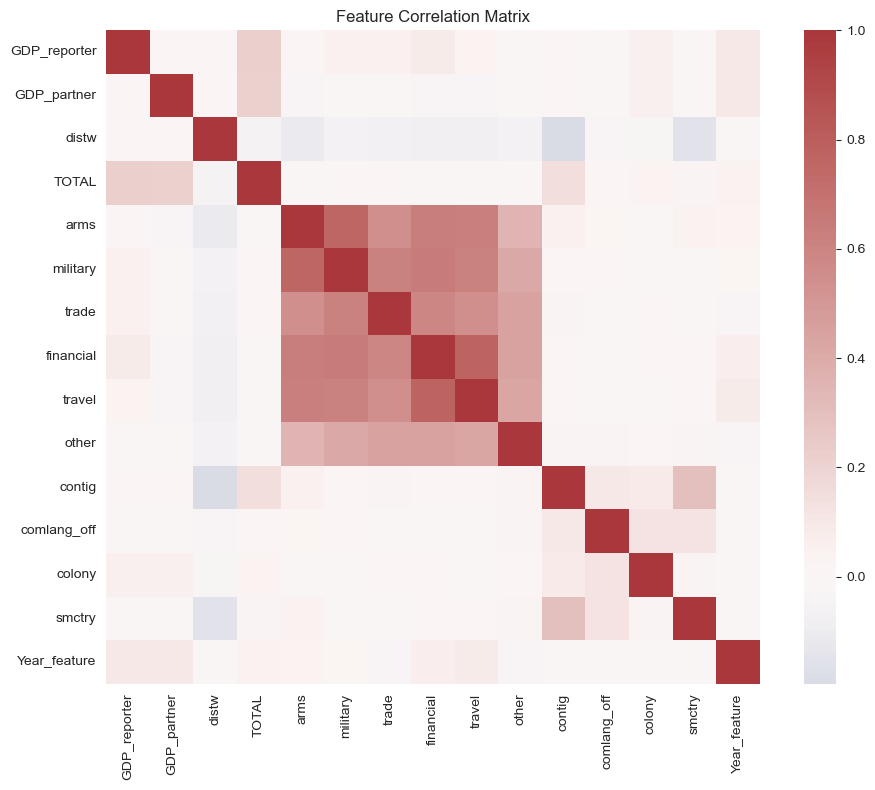

/var/folders/wz/kf7643gn3_s2867t_nnc9zxc0000gn/T/ipykernel_2082/3055013026.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="delta_rmse", y="feature", palette="mako")
/var/folders/wz/kf7643gn3_s2867t_nnc9zxc0000gn/T/ipykernel_2082/3055013026.py:52: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/thesis_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


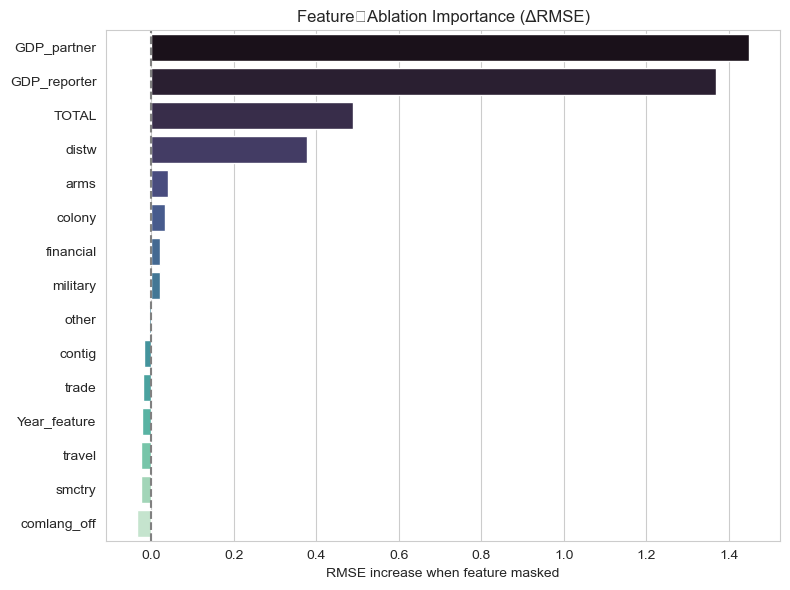

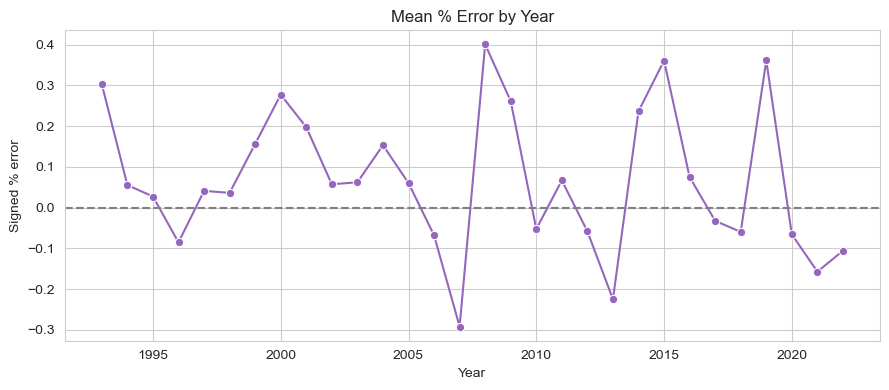

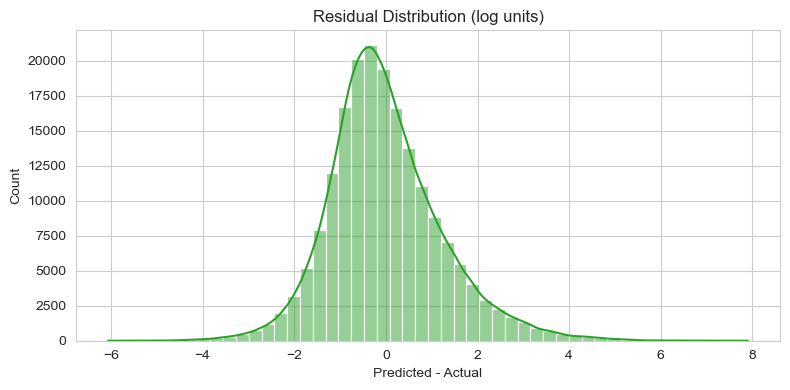

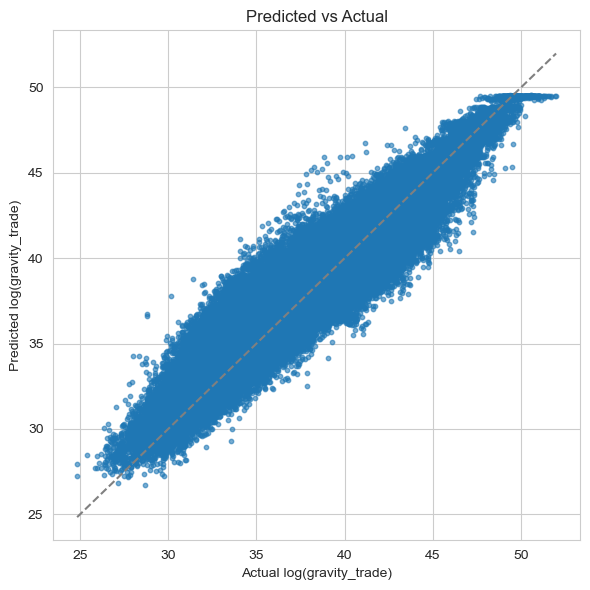

In [24]:

# ------------------------------------------------------------------
# ASSUMES:
# • df_scaled        – your DataFrame with FEATURES & 'dyad_id','Year'
# • WindowDataset    – as defined, returns (X, y, row_idx)
# • test_loader      – DataLoader over Subset(dataset, test_idx)
# • model            – trained BasicLSTM in eval() mode on device
# • FEATURES         – list of feature names, length = n_features
# ------------------------------------------------------------------

# 1) Correlation heatmap of FEATURES
plt.figure(figsize=(10, 8))
corr = df_scaled[FEATURES].corr()
sns.heatmap(corr, cmap="vlag", center=0, square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# 2) Feature‐ablation importances (ΔRMSE when masking each feature)
# gather full test arrays
X_list, y_list = [], []
for X, y, _ in test_loader:
  X_list.append(X.numpy())  # [batch, seq_len, n_features]
  y_list.append(y.numpy())
X_test = np.concatenate(X_list)  # [N, seq_len, F]
y_test = np.concatenate(y_list)  # [N]

# original RMSE
with torch.no_grad():
  preds_orig = model(torch.from_numpy(X_test).to(device)).cpu().numpy()
orig_rmse = np.sqrt(((preds_orig - y_test) ** 2).mean())

importances = []
for i, feat in enumerate(FEATURES):
  X_mask = X_test.copy()
  X_mask[:, :, i] = X_mask[:, :, i].mean()  # mask feature i
  with torch.no_grad():
    preds_mask = model(torch.from_numpy(X_mask).to(device)).cpu().numpy()
  rmse_mask = np.sqrt(((preds_mask - y_test) ** 2).mean())
  importances.append(rmse_mask - orig_rmse)

imp_df = pa.DataFrame({
  "feature": FEATURES,
  "delta_rmse": importances
}).sort_values("delta_rmse", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=imp_df, x="delta_rmse", y="feature", palette="mako")
plt.axvline(0, color="gray", linestyle="--")
plt.title("Feature‐Ablation Importance (ΔRMSE)")
plt.xlabel("RMSE increase when feature masked")
plt.ylabel("")
plt.tight_layout()
plt.show()

# 3) Mean % error by year
row_bank, preds_bank = [], []
truth_bank = []

with torch.no_grad():
  for X, y, row_idx in test_loader:
    preds_bank.append(model(X.to(device)).cpu().numpy())
    truth_bank.append(y.numpy())
    row_bank.append(row_idx.numpy())

preds_all = np.concatenate(preds_bank)
truth_all = np.concatenate(truth_bank)
rows_all = np.concatenate(row_bank)

years = df_scaled.loc[rows_all, "Year"].values
pct_err = 100 * (preds_all - truth_all) / truth_all

df_err = pa.DataFrame({ "year": years, "pct_err": pct_err })
mean_err = df_err.groupby("year")["pct_err"].mean().reset_index()

plt.figure(figsize=(9, 4))
sns.lineplot(data=mean_err, x="year", y="pct_err", marker="o", color="tab:purple")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Mean % Error by Year")
plt.ylabel("Signed % error")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

# 4) Residuals distribution
resid = preds_all - truth_all
plt.figure(figsize=(8, 4))
sns.histplot(resid, bins=50, kde=True, color="tab:green")
plt.title("Residual Distribution (log units)")
plt.xlabel("Predicted - Actual")
plt.tight_layout()
plt.show()

# 5) Predicted vs Actual scatter
plt.figure(figsize=(6, 6))
plt.scatter(truth_all, preds_all, s=10, alpha=0.6)
mn, mx = min(truth_all.min(), preds_all.min()), max(truth_all.max(), preds_all.max())
plt.plot([mn, mx], [mn, mx], color="gray", linestyle="--")
plt.xlabel("Actual log(gravity_trade)")
plt.ylabel("Predicted log(gravity_trade)")
plt.title("Predicted vs Actual")
plt.tight_layout()
plt.show()

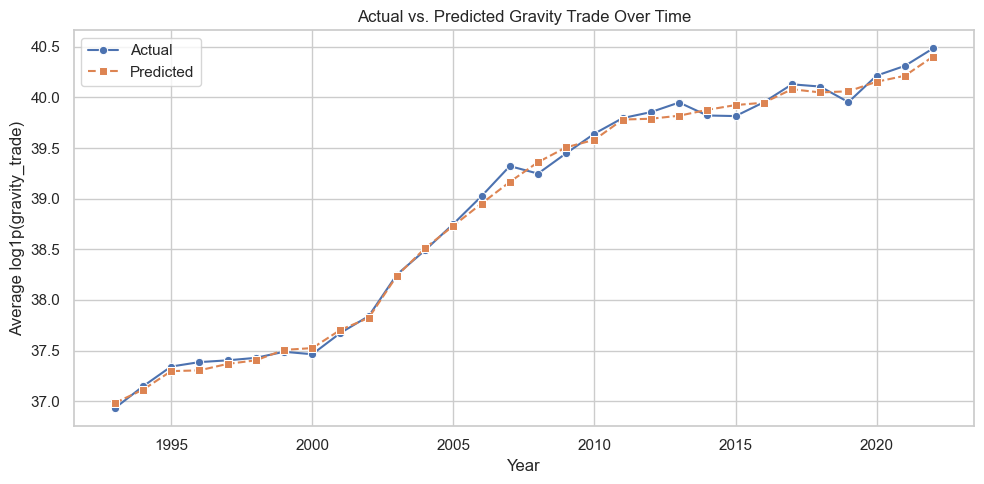

In [25]:
# ------------------------------------------------------------------------
# 1.  Collect predictions and actuals with their corresponding years
# ------------------------------------------------------------------------
row_bank, preds_bank, truth_bank = [], [], []

model.eval()
with torch.no_grad():
  for X, y, row_idx in test_loader:  # test_loader yields (X, y, row_idx)
    preds_bank.append(model(X.to(device)).cpu().numpy())
    truth_bank.append(y.numpy())
    row_bank.append(row_idx.numpy())

row_idx = np.concatenate(row_bank)  # shape [N]
preds = np.concatenate(preds_bank)  # shape [N]
truth = np.concatenate(truth_bank)  # shape [N]

# get the year for each sample
years = df_scaled.loc[row_idx, "Year"].values

# ------------------------------------------------------------------------
# 2.  Build a DataFrame and aggregate by year
# ------------------------------------------------------------------------
df_timeseries = pa.DataFrame({
  "year": years,
  "actual": truth,
  "predicted": preds
})

df_yearly = (
  df_timeseries
  .groupby("year", as_index=False)
  .agg(
    actual_mean=("actual", "mean"),
    predicted_mean=("predicted", "mean")
  )
)

# ------------------------------------------------------------------------
# 3.  Plot actual vs predicted over the years
# ------------------------------------------------------------------------
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.lineplot(
  data=df_yearly,
  x="year", y="actual_mean",
  marker="o", label="Actual"
)
sns.lineplot(
  data=df_yearly,
  x="year", y="predicted_mean",
  marker="s", linestyle="--", label="Predicted"
)
plt.xlabel("Year")
plt.ylabel("Average log1p(gravity_trade)")
plt.title("Actual vs. Predicted Gravity Trade Over Time")
plt.legend()
plt.tight_layout()
plt.show()

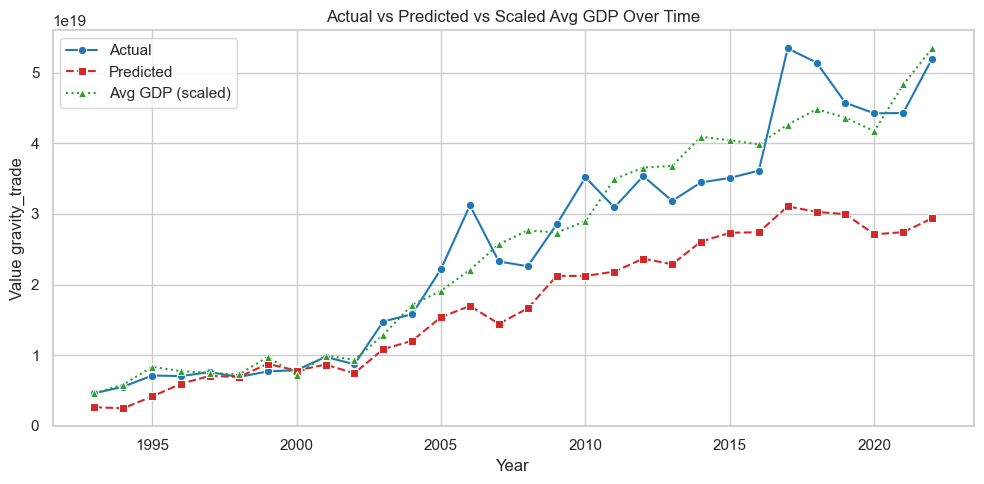

In [26]:
# ------------------------------------------------------------------------
# 1.  Collect predictions and actuals with their corresponding years
# ------------------------------------------------------------------------
row_bank, preds_bank, truth_bank = [], [], []

model.eval()
with torch.no_grad():
  for X, y, row_idx in test_loader:  # yields (X, y, row_idx)
    preds_bank.append(model(X.to(device)).cpu().numpy())
    truth_bank.append(y.numpy())
    row_bank.append(row_idx.numpy())

row_idx = np.concatenate(row_bank)  # [N]
preds = np.expm1(np.concatenate(preds_bank))  # [N]
truth = np.expm1(np.concatenate(truth_bank))  # [N]

years = df_scaled.loc[row_idx, "Year"].values

# ------------------------------------------------------------------------
# 2.  Build DataFrame and aggregate by year for actual & predicted
# ------------------------------------------------------------------------
df_timeseries = pa.DataFrame({
  "year": years,
  "actual": truth,
  "predicted": preds
})

df_yearly = (
  df_timeseries
  .groupby("year", as_index=False)
  .agg(
    actual_mean=("actual", "mean"),
    predicted_mean=("predicted", "mean")
  )
)

# ------------------------------------------------------------------------
# 3.  Compute average GDP per year and scale it to match gravity scale
# ------------------------------------------------------------------------
# average of reporter + partner GDP per year
gdp_df = df_scaled.loc[row_idx, ["Year", "GDP_reporter", "GDP_partner"]].copy()
gdp_df["gdp_avg"] = (gdp_df["GDP_reporter"] + gdp_df["GDP_partner"]) / 2

gdp_yearly = (
  gdp_df
  .groupby("Year", as_index=False)
  .agg(gdp_mean=("gdp_avg", "mean"))
  .rename(columns={ "Year": "year" })
)

# scale gdp_mean to the range of actual_mean
scaler = MinMaxScaler(feature_range=(
  df_yearly["actual_mean"].min(),
  df_yearly["actual_mean"].max()
))
gdp_yearly["gdp_scaled"] = scaler.fit_transform(
  gdp_yearly[["gdp_mean"]]
)

# merge with df_yearly
df_plot = pa.merge(df_yearly, gdp_yearly[["year", "gdp_scaled"]], on="year")

# ------------------------------------------------------------------------
# 4.  Plot all three series
# ------------------------------------------------------------------------
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))

sns.lineplot(
  data=df_plot, x="year", y="actual_mean",
  marker="o", label="Actual", color="tab:blue"
)
sns.lineplot(
  data=df_plot, x="year", y="predicted_mean",
  marker="s", linestyle="--", label="Predicted", color="tab:red"
)
sns.lineplot(
  data=df_plot, x="year", y="gdp_scaled",
  marker="^", linestyle=":", label="Avg GDP (scaled)", color="tab:green"
)

plt.xlabel("Year")
plt.ylabel("Value gravity_trade")
plt.title("Actual vs Predicted vs Scaled Avg GDP Over Time")
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
"""
---- GRU LSTM ----
"""


class GRUCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super(GRUCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
    self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)

    self.reset_parameters()

  def reset_parameters(self):
    std = 1.0 / np.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, input, hx=None):

    if hx is None:
      hx = input.new_zeros(input.size(0), self.hidden_size)

    x_t = self.x2h(input)
    h_t = self.h2h(hx)

    x_reset, x_upd, x_new = x_t.chunk(3, 1)
    h_reset, h_upd, h_new = h_t.chunk(3, 1)

    reset_gate = torch.sigmoid(x_reset + h_reset)
    update_gate = torch.sigmoid(x_upd + h_upd)
    new_gate = torch.tanh(x_new + (reset_gate * h_new))

    hy = update_gate * hx + (1 - update_gate) * new_gate

    return hy


class GruLSTM(nn.Module):
  def __init__(self,
               n_features: int,
               hidden_size: int = 128,
               n_layers: int = 2,
               dropout: float = 0.3,
               output_size: int = 1,
               bias: bool = False
               ):
    super(GruLSTM, self).__init__()

    self.bias = bias
    self.input_size = n_features
    self.hidden_size = hidden_size
    self.num_layers = n_layers
    self.dropout = dropout
    self.output_size = output_size

    self.rnn_cell_list = nn.ModuleList()
    self.rnn_cell_list.append(GRUCell(self.input_size,
                                      self.hidden_size,
                                      self.bias))
    for l in range(1, self.num_layers):
      self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                        self.hidden_size,
                                        self.bias))
    self.fc = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hx=None):
    if hx is None:
      device = input.device
      h0 = input.new_zeros(self.num_layers,
                           input.size(0),
                           self.hidden_size,
                           device=device)
    else:
      h0 = hx

    outs = []
    hidden_l = None

    hidden = list()
    for layer in range(self.num_layers):
      hidden.append(h0[layer, :, :])

    for t in range(input.size(1)):

      for layer in range(self.num_layers):

        if layer == 0:
          hidden_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer])
        else:
          hidden_l = self.rnn_cell_list[layer](hidden[layer - 1], hidden[layer])
        hidden[layer] = hidden_l

        hidden[layer] = hidden_l

      outs.append(hidden_l)
    out = outs[-1].squeeze()
    out = self.fc(out)

    return out.squeeze(1)


In [ ]:
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

best_fold_state = None  # global best
best_fold_rmse = float("inf")
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset))), 1):
  print(f"=== 🔌 FOLD {fold}/{N_SPLITS} ===")

  train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=BATCH_SIZE,
    shuffle=True
  )
  print("✳️Train loader ready")

  val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=BATCH_SIZE,
    shuffle=False
  )
  print("✳️Validation loader ready")

  model = GruLSTM(n_features=len(FEATURES)).to(device=device)

  criterion = nn.MSELoss()
  optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
  )

  best_state = copy.deepcopy(model.state_dict())
  best_rmse = float("inf")
  patience_left = PATIENCE

  for epoch in range(NUM_EPOCHS):
    # --- train ---
    model.train()
    for X, y, _ in train_loader:
      X = X.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      loss = criterion(model(X), y)
      loss.backward()
      optimizer.step()

    # --- val ---
    model.eval()
    val_losses = []
    with (torch.no_grad()):
      for X, y, _ in val_loader:
        X = X.to(device)
        y = y.to(device)
        val_losses.append(criterion(model(X), y).item())

    val_rmse = (sum(val_losses) / len(val_losses)) ** 0.5
    scheduler.step(val_rmse)
    print(f"🌯 Epoch {epoch + 1:02d}  |  val RMSE: {val_rmse:.4f}")

    if val_rmse < best_rmse - 1e-4:
      best_rmse, patience_left = val_rmse, 10
      best_state = model.state_dict()
    else:
      patience_left -= 1
      if patience_left == 0:
        print("🛑 Early stop.")
        break

  model.load_state_dict(best_state)
  model.eval();
  preds, truth = [], []
  with torch.no_grad():
    for X, y, _ in val_loader:  # “val” acts as test in CV fold
      X = X.to(device)
      preds.append(model(X).cpu());
      truth.append(y)
  preds = torch.cat(preds).numpy()
  truth = torch.cat(truth).numpy()

  rmse = np.sqrt(((preds - truth) ** 2).mean())
  mae = np.abs(preds - truth).mean()
  r2 = 1 - ((preds - truth) ** 2).sum() / ((truth - truth.mean()) ** 2).sum()
  fold_metrics.append((rmse, mae, r2))
  print(f" ⭐️ Fold {fold}  RMSE {rmse:.4f} | MAE {mae:.4f} | R² {r2:.4f}")
  if rmse < best_fold_rmse:
    best_fold_rmse = rmse
    best_fold_state = copy.deepcopy(best_state)

rmse_avg = np.mean([m[0] for m in fold_metrics])
mae_avg = np.mean([m[1] for m in fold_metrics])
r2_avg = np.mean([m[2] for m in fold_metrics])
print(f"\n💡 5‑fold mean  RMSE {rmse_avg:.4f} | MAE {mae_avg:.4f} | R² {r2_avg:.4f}")

=== 🔌 FOLD 1/5 ===
✳️Train loader ready
✳️Validation loader ready
🌯 Epoch 01  |  val RMSE: 2.5268
🌯 Epoch 02  |  val RMSE: 1.7220
🌯 Epoch 03  |  val RMSE: 1.5957
🌯 Epoch 04  |  val RMSE: 1.5907
🌯 Epoch 05  |  val RMSE: 1.4708
🌯 Epoch 06  |  val RMSE: 1.4558
🌯 Epoch 07  |  val RMSE: 1.4182
🌯 Epoch 08  |  val RMSE: 1.4550
🌯 Epoch 09  |  val RMSE: 1.3927
🌯 Epoch 10  |  val RMSE: 1.4272
🌯 Epoch 11  |  val RMSE: 1.3997
🌯 Epoch 12  |  val RMSE: 1.3405
🌯 Epoch 13  |  val RMSE: 1.3149
🌯 Epoch 14  |  val RMSE: 1.3904
🌯 Epoch 15  |  val RMSE: 1.3106
🌯 Epoch 16  |  val RMSE: 1.2970
🌯 Epoch 17  |  val RMSE: 1.3296
🌯 Epoch 18  |  val RMSE: 1.2773
🌯 Epoch 19  |  val RMSE: 1.3373
🌯 Epoch 20  |  val RMSE: 1.3124
🌯 Epoch 21  |  val RMSE: 1.2901
🌯 Epoch 22  |  val RMSE: 1.2643
🌯 Epoch 23  |  val RMSE: 1.2869
🌯 Epoch 24  |  val RMSE: 1.2787
🌯 Epoch 25  |  val RMSE: 1.2796
🌯 Epoch 26  |  val RMSE: 1.2619
🌯 Epoch 27  |  val RMSE: 1.2037
🌯 Epoch 28  |  val RMSE: 0.9460
🌯 Epoch 29  |  val RMSE: 0.7952
🌯 Epoc

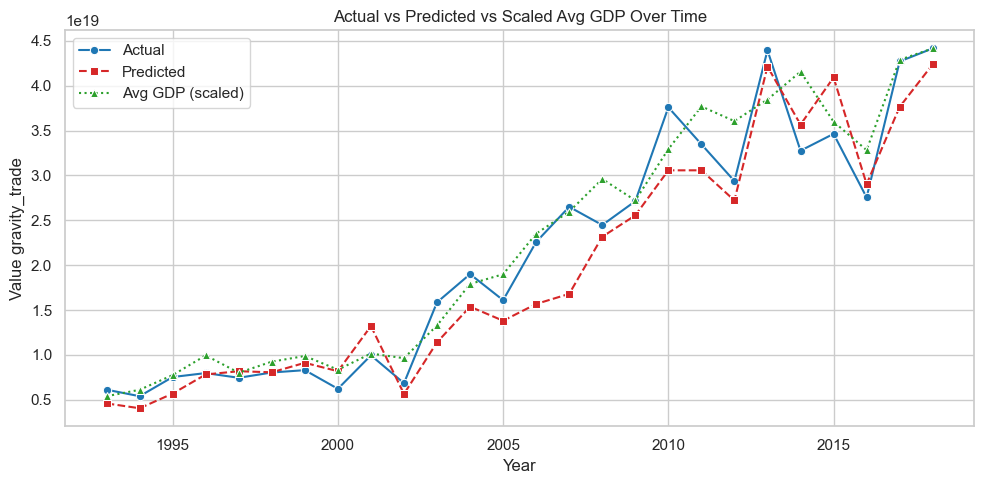

In [43]:
# ------------------------------------------------------------------------
# 1.  Collect predictions and actuals with their corresponding years
# ------------------------------------------------------------------------
row_bank, preds_bank, truth_bank = [], [], []

model.eval()
with torch.no_grad():
  for X, y, row_idx in test_loader:  # yields (X, y, row_idx)
    preds_bank.append(model(X.to(device)).cpu().numpy())
    truth_bank.append(y.numpy())
    row_bank.append(row_idx.numpy())

row_idx = np.concatenate(row_bank)  # [N]
preds = np.expm1(np.concatenate(preds_bank))  # [N]
truth = np.expm1(np.concatenate(truth_bank))  # [N]

years = df_scaled.loc[row_idx, "Year"].values

# ------------------------------------------------------------------------
# 2.  Build DataFrame and aggregate by year for actual & predicted
# ------------------------------------------------------------------------
df_timeseries = pa.DataFrame({
  "year": years,
  "actual": truth,
  "predicted": preds
})

df_yearly = (
  df_timeseries
  .groupby("year", as_index=False)
  .agg(
    actual_mean=("actual", "mean"),
    predicted_mean=("predicted", "mean")
  )
)

# ------------------------------------------------------------------------
# 3.  Compute average GDP per year and scale it to match gravity scale
# ------------------------------------------------------------------------
# average of reporter + partner GDP per year
gdp_df = df_scaled.loc[row_idx, ["Year", "GDP_reporter", "GDP_partner"]].copy()
gdp_df["gdp_avg"] = (gdp_df["GDP_reporter"] + gdp_df["GDP_partner"]) / 2

gdp_yearly = (
  gdp_df
  .groupby("Year", as_index=False)
  .agg(gdp_mean=("gdp_avg", "mean"))
  .rename(columns={ "Year": "year" })
)

# scale gdp_mean to the range of actual_mean
scaler = MinMaxScaler(feature_range=(
  df_yearly["actual_mean"].min(),
  df_yearly["actual_mean"].max()
))
gdp_yearly["gdp_scaled"] = scaler.fit_transform(
  gdp_yearly[["gdp_mean"]]
)

# merge with df_yearly
df_plot = pa.merge(df_yearly, gdp_yearly[["year", "gdp_scaled"]], on="year")

# ------------------------------------------------------------------------
# 4.  Plot all three series
# ------------------------------------------------------------------------
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))

sns.lineplot(
  data=df_plot, x="year", y="actual_mean",
  marker="o", label="Actual", color="tab:blue"
)
sns.lineplot(
  data=df_plot, x="year", y="predicted_mean",
  marker="s", linestyle="--", label="Predicted", color="tab:red"
)
sns.lineplot(
  data=df_plot, x="year", y="gdp_scaled",
  marker="^", linestyle=":", label="Avg GDP (scaled)", color="tab:green"
)

plt.xlabel("Year")
plt.ylabel("Value gravity_trade")
plt.title("Actual vs Predicted vs Scaled Avg GDP Over Time")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
"""
---- Train Model ----
"""
# model = BasicLSTM(n_features=len(FEATURES)).to(device=device)
#
# criterion = nn.MSELoss()
# optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#   optimizer, mode="min", factor=0.5, patience=3
# )
#
# best_state, best_rmse, patience_left = model.state_dict(), float("inf"), PATIENCE
#
# for epoch in range(NUM_EPOCHS):
#   # --- train ---
#   model.train()
#   for X, y in train_loader:
#     X = torch.tensor(X).to(device)
#     y = torch.tensor(y).to(device)
#     optimizer.zero_grad()
#     loss = criterion(model(X), y)
#     loss.backward()
#     optimizer.step()
#
#   # --- val ---
#   model.eval()
#   val_losses = []
#   with torch.no_grad():
#     for X, y in val_loader:
#       X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)
#       val_losses.append(criterion(model(X), y).item())
#
#   val_rmse = (sum(val_losses) / len(val_losses)) ** 0.5
#   scheduler.step(val_rmse)
#   print(f"🌯 Epoch {epoch + 1:02d}  |  val RMSE: {val_rmse:.4f}")
#   # --- early‑stop ---
#   if val_rmse < best_rmse - 1e-4:
#     best_rmse, patience_left = val_rmse, 10
#     best_state = model.state_dict()
#   else:
#     patience_left -= 1
#     if patience_left == 0:
#       print("🛑 Early stop.")
#       break

'\n---- Train Model ----\n'

In [17]:
"""
---- TEST MODEL ----
"""
# model.load_state_dict(best_state)
# model.eval()
# preds, truth = [], []
# with torch.no_grad():
#   for X, y in test_loader:
#     X = torch.tensor(X).to(device)
#     preds.append(model(X).cpu())
#     truth.append(torch.tensor(y))
# preds = torch.cat(preds).numpy()
# truth = torch.cat(truth).numpy()
#
# rmse = (((preds - truth) ** 2).mean()) ** 0.5
# mae = (abs(preds - truth)).mean()
# r2 = 1 - ((preds - truth) ** 2).sum() / ((truth - truth.mean()) ** 2).sum()
# adj_r2 = 1 - (1 - r2) * (len(truth) - 1) / (len(truth) - len(FEATURES) - 1)
#
# print(f"🚨 Test  RMSE: {rmse:.4f} |  MAE: {mae:.4f} |  R²: {r2:.4f} |  adj R²: {adj_r2:.4f}")

'\n---- TEST MODEL ----\n'